# Comparing Molecules among Molecular Libraries

In [85]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

#### Load the data

In [86]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './fxa_rdkit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [87]:
print(lig_datasets.keys())
print('\n' + '-'* 50 + '\nExample:')
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'DUD', 'DEKOIS'])

--------------------------------------------------
Example:


,Activity,mol_rdk,sanitized
Lig,,,
RPR,active,<rdkit.Chem.rdchem.Mol object at 0x7f33da293c30>,False
815,active,<rdkit.Chem.rdchem.Mol object at 0x7f33da293030>,True
PR2,active,<rdkit.Chem.rdchem.Mol object at 0x7f33da293b30>,True


## Using RDKit to evaluate some molecular descriptors
##### The following function computes some features like Molecular Mass, number of heavy atoms, number of rotamers and number of rings.

In [88]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]

### Plots

In [89]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

In [90]:
# Declare a color palette
# palette = ['#2F9C53', '#FBB300', '#9166DC', '#F55036']
# swarm_plot_helper('MW', lig_datasets,
  #                 title = 'Molecular Mass of the four libraries', palette= palette,
  #                 xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split=False, size=2.7)
# too many points!! let's use a violin plot instead..

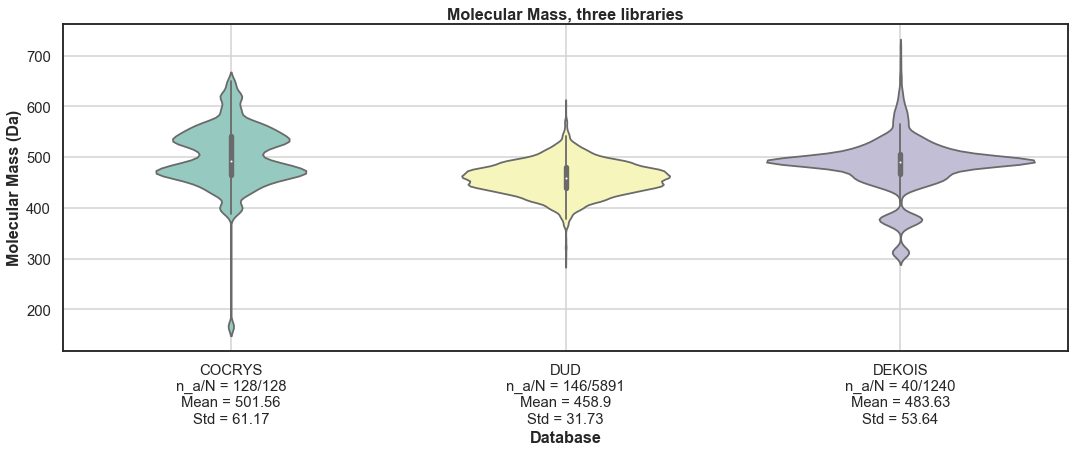

In [91]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries', palette= 'Set3',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False, )

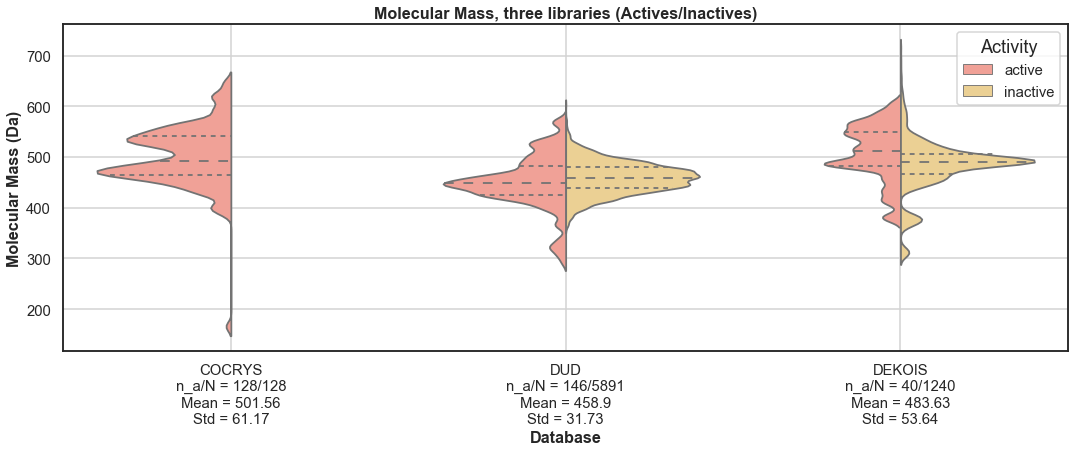

In [92]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

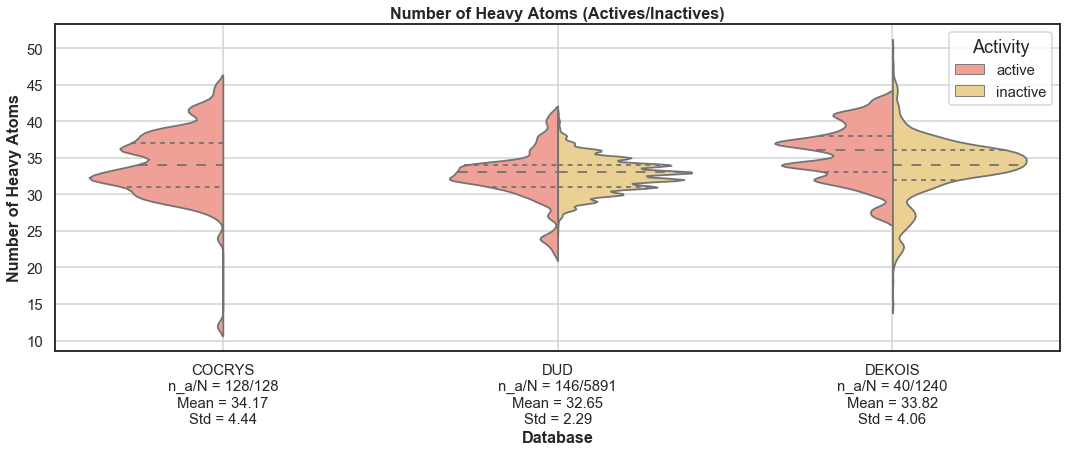

In [93]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

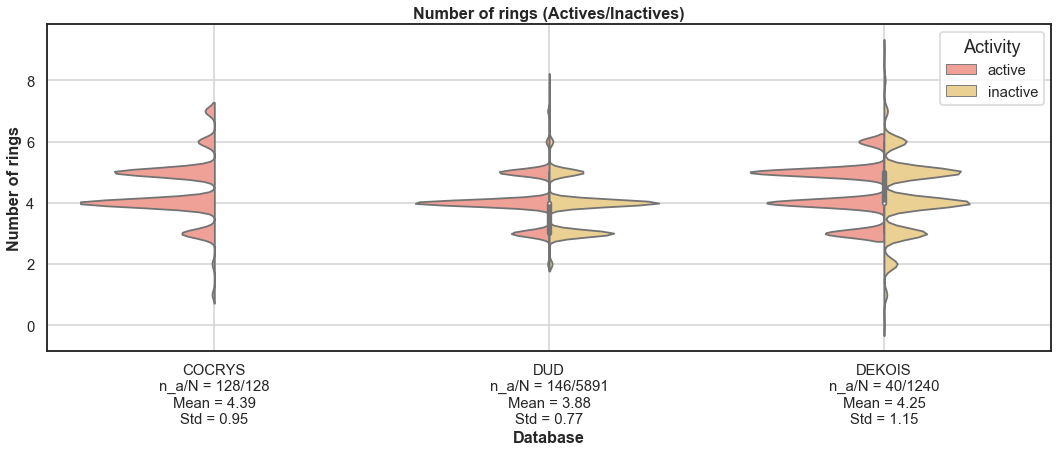

In [94]:
violin_plot_helper('num_rings', lig_datasets,
                   title = 'Number of rings (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'],
                   xlabel= 'Database', ylabel = 'Number of rings', split_by_activity=True)

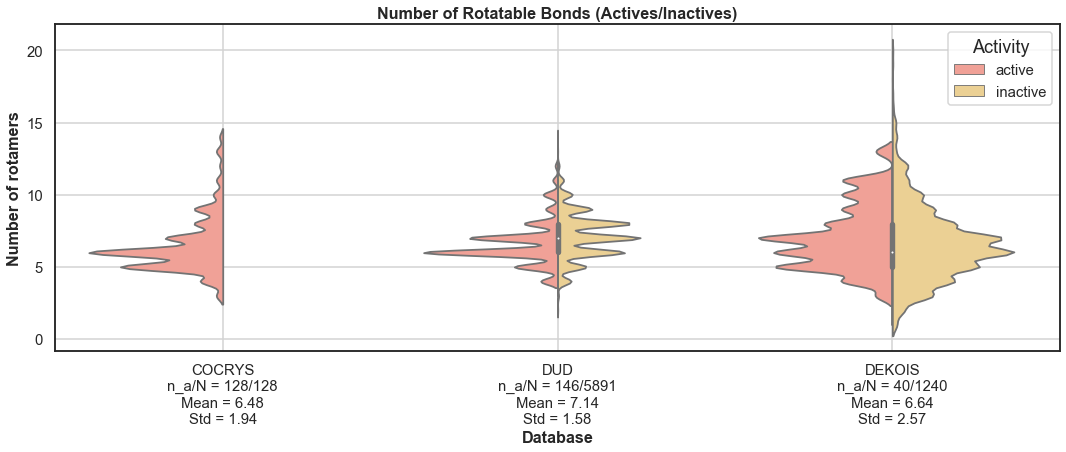

In [95]:
violin_plot_helper('num_rot', lig_datasets,
                   title = 'Number of Rotatable Bonds (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'],
                   xlabel= 'Database', ylabel = 'Number of rotamers', split_by_activity=True)

### Fingerprints

In [105]:
from rdkit.Chem import MACCSkeys

for dataset in lig_datasets.values():
    # MACCS Keys Fingetprints
    dataset['fps_maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in dataset['mol_rdk']]

In [ ]:
lig_datasets['COCRYS'][['fps_maccs']].loc['815', :]

In [ ]:
for dataset in lig_datasets.values():
    # RDKit Fingetprints
    dataset['fps_rdk'] = [Chem.RDKFingerprint(i, fpSize=2048, minPath=1, maxPath=7)
                          for i in dataset['mol_rdk']]

In [ ]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

In [ ]:
%%time
matched_ligands = compare_lig_db('fps_maccs', lig_datasets, method = 'tanimoto')

In [ ]:
draw_matched_ligs('DUD-DEKOIS', matched_ligands)

### Dimensionality Reduction
#### Merge the data frames

In [108]:
# Get a dataframe for each library 
library_names = ['COCRYS', 'DEKOIS', 'DUD']
dfs_list = []

# add a new column
for name in library_names:
    df = lig_datasets[name]
    # Add new column with its name
    df['library'] = name
    # Append to the df list
    dfs_list.append(df)

# Concat
df_all_mols = pd.concat(dfs_list, ignore_index=False).reset_index()

### t-SNE
#### MACCS-Keys

In [132]:
%%time
s = df_all_mols['fps_maccs'].map(list)
df_maccs_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T

CPU times: user 8.12 s, sys: 292 ms, total: 8.42 s
Wall time: 7.96 s


In [133]:
from sklearn.manifold import TSNE

In [143]:
%%time
# Compute the t-sne 
tsne = TSNE(learning_rate=50)
tsne_dims = tsne.fit_transform(df_maccs_all)
# Create a dataframe with t-sne dimensions and other features
df_dims = df_all_mols.copy()[['library', 'index', 'Activity', 'num_rings', 'num_atoms', 'num_rot']]
# append the tsne_dims
df_dims['tsne_x'] = tsne_dims[:, 0]
df_dims['tsne_y'] = tsne_dims[:, 1]

CPU times: user 3min 55s, sys: 2min 53s, total: 6min 49s
Wall time: 1min 19s


## Plot with bokeh

In [310]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, Span
from bokeh.transform import factor_cmap, factor_mark
output_notebook()

Loading BokehJS ...

In [326]:
# Create the columndatasource
source = ColumnDataSource(data= df_dims)

# Filters
actives_source = CDSView(source=source, 
                        filters=[GroupFilter(column_name='Activity', group='active')])
inactives_source = CDSView(source=source, 
                        filters=[GroupFilter(column_name='Activity', group='inactive')])

# Create the color and marker mappers
LIBRARIES = np.unique(source.data['library'])
ACTIVITY = np.unique(source.data['Activity'])

# Color mappers
col_library_map = factor_cmap('library', ['#20C55A', '#FF5733', '#857CEA'], LIBRARIES)
col_activity_map = factor_cmap('Activity', ['#df4834', '#fda200'], ACTIVITY)
# Marker mapper
marker_activity_map = factor_mark('Activity', ['triangle', 'circle'], ACTIVITY)

# Create the figure
f = figure(title='t-SNE - MACCS Keys: FXa Molecules', plot_width=800, plot_height=800,
          x_axis_label='First Dimension', y_axis_label='Second Dimension')

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='black', line_width=2, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='black', line_width=2, line_dash='dashed')
f.renderers.extend([vline, hline])

# Add glyphs
# Plot inactives
f.circle(x='tsne_x', y='tsne_y',
           color=col_library_map,
           size=5, alpha=0.3, line_width=0,
           legend_group='library',
           muted_alpha=0.01,
           source=source, view=inactives_source)

# Plot actives
f.triangle(x='tsne_x', y='tsne_y',
           color=col_library_map,
           size=10, line_color='black', line_width=0.8,
           legend_label='ACTIVES',
           source=source, view=actives_source)



# Styling
f.title.text_font_size = '1.5em'
f.axis.axis_label_text_font_size = '1.2em' # font size
f.title.align = 'center'
f.axis.axis_line_width = 3
f.axis.major_label_text_font_size = '11pt'
f.legend.click_policy='mute'


show(f)

### Tanimoto Heatmap

In [239]:
from scipy.spatial.distance import pdist, squareform

In [255]:
df_all_mols.groupby('Activity').count()['index']
df_all_mols[df_all_mols.Activity == 'active']

Activity
active       314
inactive    6945
Name: index, dtype: int64

In [274]:
%%time
actives_filter = df_all_mols.Activity == 'active'
df_actives = df_all_mols[actives_filter]
df = df_maccs_all[actives_filter]
dist_mtx = squareform( pdist(df, 'jaccard') )
siml_mtx = 1 - dist_mtx

CPU times: user 26.1 ms, sys: 3.22 ms, total: 29.4 ms
Wall time: 26.5 ms


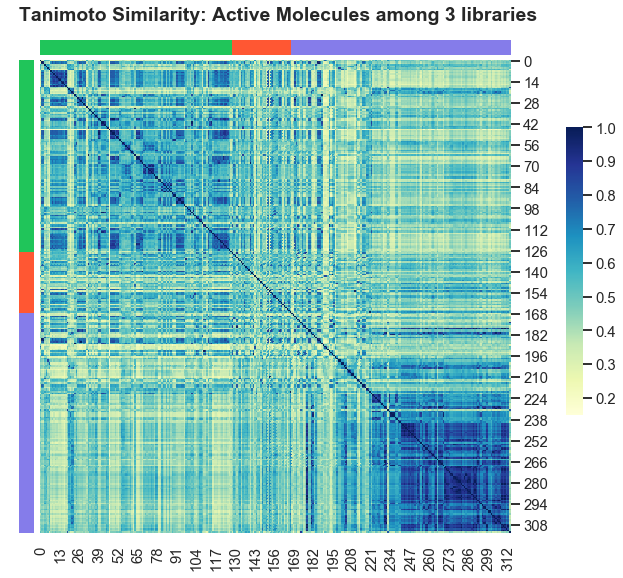

In [302]:
# Colors
library_colors = ['#20C55A' if i == 'COCRYS' else '#FF5733' if i == 'DEKOIS' else '#857CEA' for i in df_actives.library]

clusmap = sns.clustermap(siml_mtx, cmap='YlGnBu',
                        col_cluster=False, 
                        row_cluster=False,
                        col_colors=library_colors,
                         row_colors=library_colors,
                         cbar_pos=(1, 0.3, 0.03, 0.5),
                         dendrogram_ratio= (0.01, 0.01),
                         figsize=(8,8)
                        )
ax = clusmap.ax_heatmap
clusmap.fig.suptitle('Tanimoto Similarity: Active Molecules among 3 libraries', y=1.01, fontweight='bold')
plt.show()

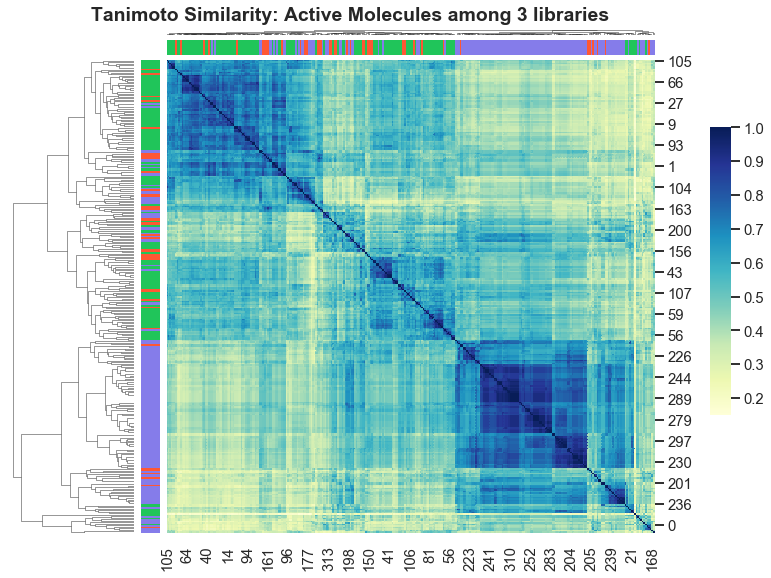

In [301]:
# Colors
library_colors = ['#20C55A' if i == 'COCRYS' else '#FF5733' if i == 'DEKOIS' else '#857CEA' for i in df_actives.library]

clusmap = sns.clustermap(siml_mtx, cmap='YlGnBu',
                        #col_cluster=False, 
                        #row_cluster=False,
                        col_colors=library_colors,
                         row_colors=library_colors,
                         cbar_pos=(1, 0.3, 0.03, 0.5),
                         dendrogram_ratio= (0.20, 0.01),
                         figsize=(10,8)
                        )
ax = clusmap.ax_heatmap
clusmap.fig.suptitle('Tanimoto Similarity: Active Molecules among 3 libraries', y=1.01, fontweight='bold')
plt.show()

### Morgan Fingerprints


## Murcko Scaffold

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold as Murko
from rdkit.Chem import rdDepictor

In [ ]:
mol_rpr = lig_datasets['COCRYS'].loc['RPR', 'mol_rdk']
rdDepictor.Compute2DCoords(mol_rpr)
mol_rpr

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)

In [ ]:
# generic
Murko.MakeScaffoldGeneric(mol_rpr)

In [ ]:
mol_rpr = lig_datasets['COCRYS'].loc['4O4', 'mol_rdk']
rdDepictor.Compute2DCoords(mol_rpr)
mol_rpr

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)